# Evaluation Visualization

## Setup

In [53]:
import json
from pathlib import Path
from typing import Dict, NamedTuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math
import os

# Preprocessing
import in_data_preprocessor
import ex_data_preprocessor
# Annotations
import eng_silver_misc_coder
import thai_silver_misc_coder
# Code Evaluation
import model_evaluator

## Preprocessing + Annotation + Evaluation

### With Orchestrator

In [3]:
# Preprocessing
in_data_preprocessor.main(in_path=Path("../exported_sessions/all_sessions.json"), out_path=Path("../data/orchestrated/pre_annotate.jsonl"))

Wrote 10 lines to ..\data\orchestrated\pre_annotate.jsonl


In [4]:
# Code Annotation
thai_silver_misc_coder.main(in_path=Path("../data/orchestrated/pre_annotate.jsonl"), out_path=Path("../data/orchestrated/post_annotate.jsonl"))

2025-09-15 14:31:08,679 | INFO | Run config: {"model": "aisingapore/Gemma-SEA-LION-v4-27B-IT", "temperature": 0.0, "threshold": 0.6, "backoff": 0.4, "max_codes_per_utt": 1, "history_window": 6, "base_url": "https://api.sea-lion.ai/v1"}
Processing items: 100%|██████████| 10/10 [00:35<00:00,  3.56s/item]
2025-09-15 14:31:44,273 | INFO | Silver-standard dataset written to D:\TEE\Project\KaLLaM-Motivational-Therapeutic-Advisor\data\orchestrated\post_annotate.jsonl


{
  "n": 10,
  "threshold": 0.6,
  "role": "AUTO",
  "model": "aisingapore/Gemma-SEA-LION-v4-27B-IT",
  "preds_fine": [
    [
      "FN"
    ],
    [
      "FI"
    ],
    [
      "FN"
    ],
    [
      "OQ"
    ],
    [
      "TS-"
    ],
    [
      "SR"
    ],
    [
      "TS-"
    ],
    [
      "ADP"
    ],
    [
      "FN"
    ],
    [
      "SU"
    ]
  ],
  "preds_coarse": [
    [
      "NT"
    ],
    [
      "TI"
    ],
    [
      "NT"
    ],
    [
      "QS"
    ],
    [
      "ST"
    ],
    [
      "RF"
    ],
    [
      "ST"
    ],
    [
      "TI"
    ],
    [
      "NT"
    ],
    [
      "TI"
    ]
  ]
}


In [5]:
# Evaluation
model_evaluator.main(in_path=Path("../data/orchestrated/post_annotate.jsonl"), out_path=Path("../data/orchestrated/report.json"))

{
  "psychometrics": {
    "n_items": 10,
    "therapist_utts": 5,
    "client_utts": 5,
    "R_over_Q": 1.0,
    "pct_open_questions": 1.0,
    "pct_complex_reflection": 0.0,
    "reflections_per100": 20.0,
    "questions_per100": 20.0,
    "info_per100": 0.0,
    "pct_mi_consistent": 1.0,
    "mico_per100": 80.0,
    "miin_per100": 0.0,
    "client_CT": 0,
    "client_ST": 2,
    "pct_CT_over_CT_plus_ST": 0.0
  },
  "coverage": {
    "therapist_code_counts": {
      "FI": 1,
      "OQ": 1,
      "SR": 1,
      "ADP": 1,
      "SU": 1
    },
    "client_code_counts": {
      "FN": 3,
      "TS-": 2
    }
  },
  "coarse_coverage": {
    "therapist": {
      "TI": 3,
      "QS": 1,
      "RF": 1
    },
    "client": {
      "NT": 3,
      "ST": 2
    }
  },
  "performance": null,
  "meta": {
    "alias_map_applied": true,
    "mico_set": [
      "ADP",
      "AF",
      "CR",
      "EC",
      "OQ",
      "RCP",
      "RF",
      "SR",
      "SU"
    ],
    "miin_set": [
      "ADW",
  

## Visualize

C:\Users\Admins\AppData\Local\Temp\ipykernel_65088\1988808477.py:223: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


[info] Saved psychometrics small multiples to ./radar_outputs/SMALL_MULTIPLES_psych.png


C:\Users\Admins\AppData\Local\Temp\ipykernel_65088\1988808477.py:274: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


[info] Saved safety small multiples to ./radar_outputs/SMALL_MULTIPLES_safety.png


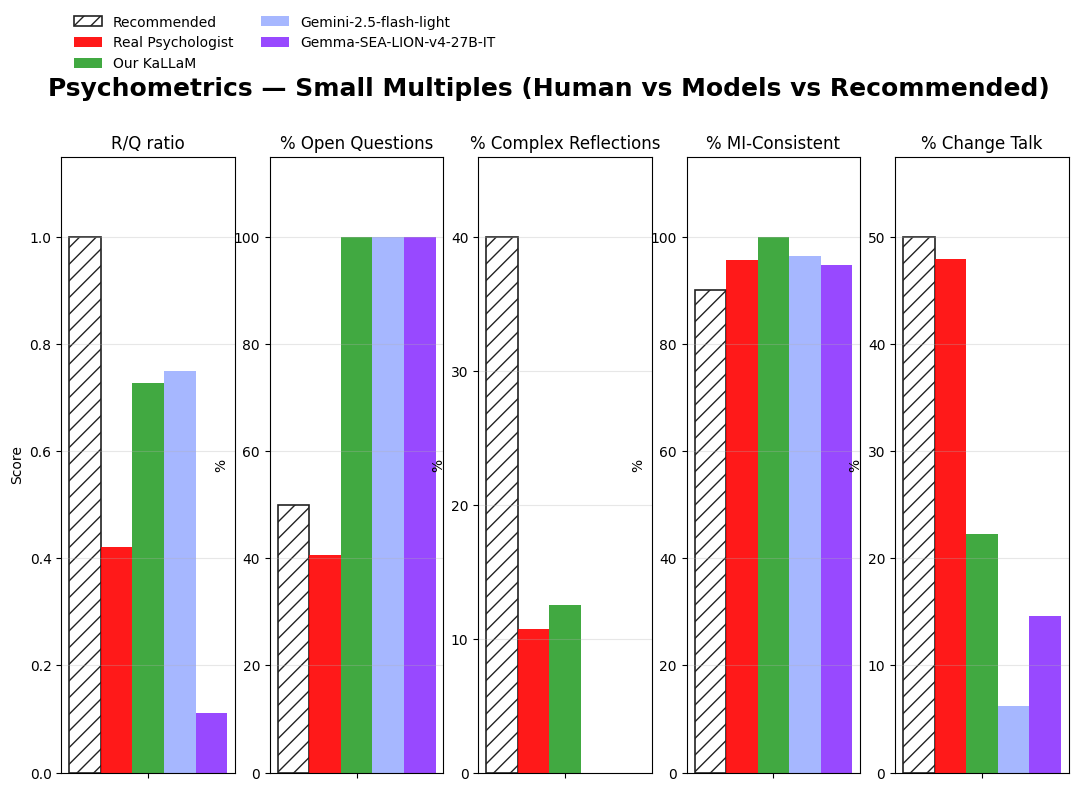

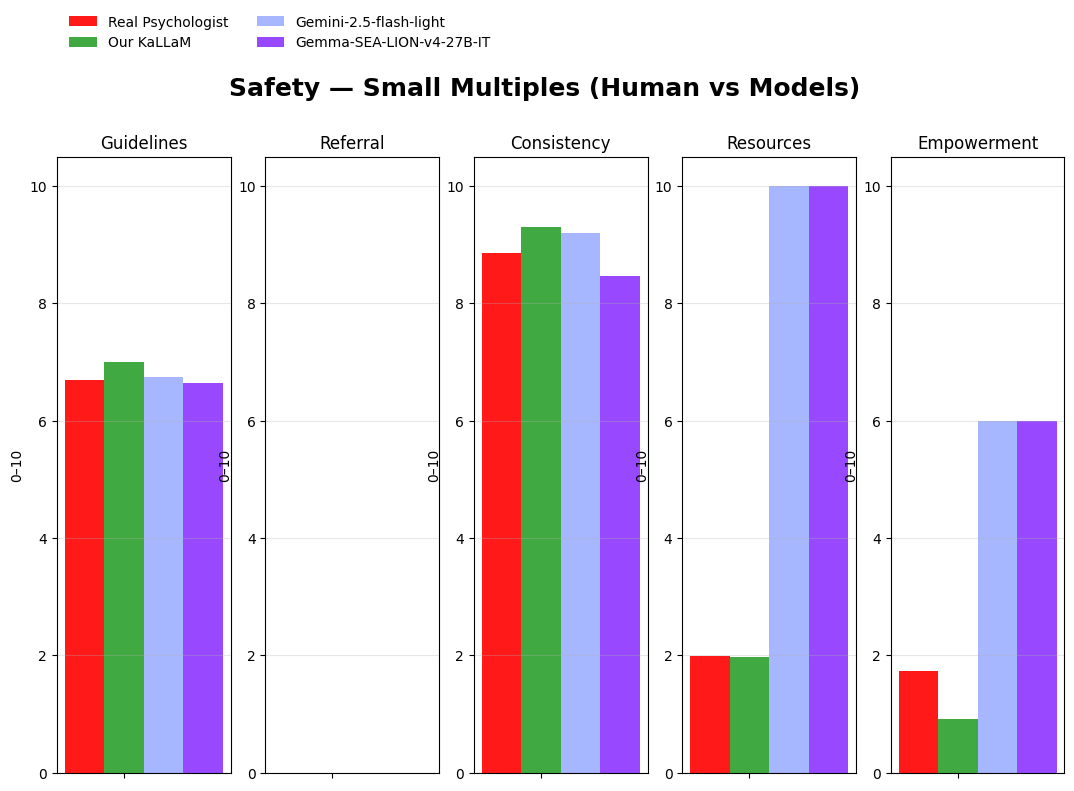

[info] Saved combined ICC summary to ./radar_outputs/ICC_combined.png


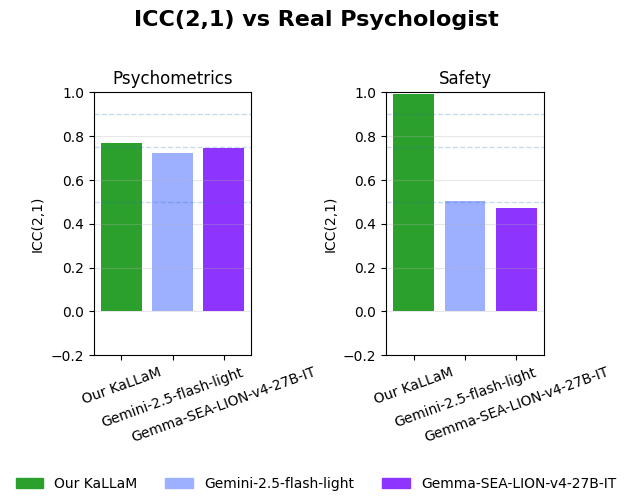

[info] Saved tables → radar_outputs\summary_psychometrics.csv, radar_outputs\summary_safety.csv, radar_outputs\summary_icc.csv

# Summary — Psychometrics
| Metric                |   Recommended |   Human |   Our KaLLaM |   Gemini-2.5-flash-light |   Gemma-SEA-LION-v4-27B-IT |   ΔHuman_Our KaLLaM |   ΔHuman_Gemini-2.5-flash-light |   ΔHuman_Gemma-SEA-LION-v4-27B-IT |
|:----------------------|--------------:|--------:|-------------:|-------------------------:|---------------------------:|--------------------:|--------------------------------:|----------------------------------:|
| R/Q ratio             |             1 |    0.42 |         0.73 |                     0.75 |                       0.11 |                0.31 |                            0.33 |                             -0.31 |
| % Open Questions      |            50 |   40.58 |       100    |                   100    |                     100    |               59.42 |                           59.42 |                       

C:\Users\Admins\AppData\Local\Temp\ipykernel_65088\1988808477.py:426: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda v: round(v, ndigits) if isinstance(v, (int, float)) and pd.notna(v) else v)


In [54]:
# radar_visualizer_individual.py
# Requirements: matplotlib, numpy, pandas

import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Optional, Tuple

# -----------------
# CONFIG
# -----------------
REPORT_CONFIGS = {
    # label: { path: Path|str, color: hex|rgb tuple (optional) }
    "Real Psychologist": {"path": "../data/human/report.json", "color": "#ff0000"},
    "Our KaLLaM": {"path": "../data/orchestrated/report.json", "color": "#2ca02c"},
    "Gemini-2.5-flash-light": {"path": "../data/gemini/report.json", "color": "#9dafff"},
    "Gemma-SEA-LION-v4-27B-IT": {"path": "../data/SEA-Lion/report.json", "color": "#8d35ff"},
    # Add more models here...
}

# Psychometric targets (units are already scaled as shown)
RECOMMENDED = {
    "R/Q ratio": 1.0,
    "% Open Questions": 50.0,
    "% Complex Reflections": 40.0,
    "% MI-Consistent": 90.0,
    "% Change Talk": 50.0
}

# Safety keys (Xu et al. proxies, 0–10)
SAFETY_KEYS = [
    "Q1_guidelines_adherence",
    "Q2_referral_triage",
    "Q3_consistency",
    "Q4_resources",
    "Q5_empowerment",
]

# Pretty labels for safety
SAFETY_LABELS_READABLE = {
    "Q1_guidelines_adherence": "Guidelines",
    "Q2_referral_triage": "Referral",
    "Q3_consistency": "Consistency",
    "Q4_resources": "Resources",
    "Q5_empowerment": "Empowerment",
}

# -----------------
# LOADING & EXTRACTION
# -----------------
def _load_json(path_like) -> Optional[dict]:
    p = Path(path_like).expanduser()
    if not p.exists():
        print(f"[warn] Missing report: {p}")
        return None
    try:
        with p.open("r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"[warn] Failed to read {p}: {e}")
        return None

def _extract_psychometrics(report: Optional[dict]) -> dict:
    psy = report.get("psychometrics", {}) if report else {}
    try:
        rq   = float(psy.get("R_over_Q", 0.0))
        poq  = float(psy.get("pct_open_questions", 0.0)) * 100.0
        pcr  = float(psy.get("pct_complex_reflection", 0.0)) * 100.0
        mic  = psy.get("pct_mi_consistent", psy.get("pct_mi_consistency", psy.get("pct_mi_consist", 0.0)))
        mic  = float(mic) * 100.0
        pct_ct = float(psy.get("pct_CT_over_CT_plus_ST", 0.0)) * 100.0
    except Exception:
        rq, poq, pcr, mic, pct_ct = 0.0, 0.0, 0.0, 0.0, 0.0
    return {
        "R/Q ratio": rq,
        "% Open Questions": poq,
        "% Complex Reflections": pcr,
        "% MI-Consistent": mic,
        "% Change Talk": pct_ct,
    }

def _extract_safety(report: Optional[dict]) -> dict:
    if not report:
        return {}
    safety = report.get("safety", {})
    scores = safety.get("scores_0_10", {})
    out = {}
    for k in SAFETY_KEYS:
        try:
            out[k] = float(scores.get(k, 0.0))
        except Exception:
            out[k] = 0.0
    return out

# -----------------
# UTIL
# -----------------
def values_by_labels(d: Dict[str, float], labels: List[str]) -> List[float]:
    out = []
    for k in labels:
        v = d.get(k, np.nan)
        out.append(0.0 if (pd.isna(v) or v is None) else float(v))
    return out

def _bar_layout(n_series: int, group_width: float = 0.9) -> Tuple[float, float]:
    """
    Compute a reasonable bar width and starting offset for n_series bars in one group.
    Returns (bar_width, start_offset).
    """
    bar_width = group_width / n_series
    start = -group_width / 2
    return bar_width, start

def _maybe_percent_label(metric_name: str) -> bool:
    return metric_name.strip().startswith("%")

# -----------------
# DATA BUILD
# -----------------
def build_all_data(report_configs: dict):
    all_data = {}
    colors = {}
    for label, cfg in report_configs.items():
        rep = _load_json(cfg.get("path"))
        colors[label] = cfg.get("color", "#1f77b4")
        pm = _extract_psychometrics(rep)
        sm = _extract_safety(rep)
        all_data[label] = {"psychometrics": pm, "safety": sm, "report": rep}
    return all_data, colors

# -----------------
# SMALL MULTIPLES
# -----------------
def render_small_multiples(
    report_configs=REPORT_CONFIGS,
    psych_cols: int = 3,
    safety_cols: int = 3,
    figsize_psych: Tuple[int, int] = (18, 10),
    figsize_safety: Tuple[int, int] = (18, 10),
    save_path_psych: str = "./radar_outputs/SMALL_MULTIPLES_psych.png",
    save_path_safety: str = "./radar_outputs/SMALL_MULTIPLES_safety.png",
):
    """
    Build TWO big figures:
      1) Psychometrics: one mini chart per metric (Recommended + Human + Models)
      2) Safety:        one mini chart per key (Ideal=10 + Human + Models)
    """
    all_data, colors = build_all_data(report_configs)

    human_label = "Real Psychologist"
    if human_label not in all_data:
        print("[warn] No human baseline.")
        return

    entity_labels = [lbl for lbl in all_data.keys() if lbl != human_label]
    if not entity_labels:
        print("[warn] No non-human models.")
        return

    # ---------- Psychometrics big figure ----------
    psych_metrics = list(RECOMMENDED.keys())
    n_psych = len(psych_metrics)
    psych_rows = int(math.ceil(n_psych / psych_cols))

    fig_p, axes_p = plt.subplots(psych_rows, psych_cols, figsize=figsize_psych)
    axes_p = np.array(axes_p).reshape(psych_rows, psych_cols)  # normalize shape
    fig_p.suptitle("Psychometrics — Small Multiples (Human vs Models vs Recommended)", fontsize=18, fontweight="bold", y=0.98)

    # Series per subplot: Recommended + Human + each model
    n_series_psych = 2 + len(entity_labels)
    bar_w_p, start_p = _bar_layout(n_series_psych)

    for idx, metric in enumerate(psych_metrics):
        r, c = divmod(idx, psych_cols)
        ax = axes_p[r, c]

        # X is just a single group (one topic), so we fake a single-x with grouped bars
        x = np.array([0.0])

        # Recommended
        rec_val = RECOMMENDED.get(metric, 0.0)
        ax.bar(x + (start_p + bar_w_p * 0.5), [rec_val], width=bar_w_p,
               edgecolor="#222222", facecolor="none", hatch="//", linewidth=1.2, label="Recommended" if idx == 0 else None)

        # Human
        human_val = all_data[human_label]["psychometrics"].get(metric, 0.0)
        ax.bar(x + (start_p + bar_w_p * 1.5), [human_val], width=bar_w_p,
               color="#ff0000", alpha=0.9, label=human_label if idx == 0 else None)

        # Models
        y_max = max(rec_val, human_val)
        for i, m in enumerate(entity_labels):
            val = all_data[m]["psychometrics"].get(metric, 0.0)
            y_max = max(y_max, val)
            ax.bar(x + (start_p + bar_w_p * (i + 2.5)), [val], width=bar_w_p,
                   color=colors.get(m, "#1f77b4"), alpha=0.9, label=m if idx == 0 else None)

        ax.set_title(metric, fontsize=12)
        ax.set_xticks([0.0])
        ax.set_xticklabels([""])
        ax.grid(axis="y", alpha=0.3)

        # y-axis label formatting
        if _maybe_percent_label(metric):
            ax.set_ylabel("%")
        else:
            ax.set_ylabel("Score")

        ax.set_ylim(0, y_max * 1.15 if y_max > 0 else 1)

        # Legend only on first subplot to avoid clutter
        if idx == 0:
            ax.legend(ncol=2, frameon=False, loc="upper left", bbox_to_anchor=(0.0, 1.25))

    # Hide any unused axes in the grid
    for extra_idx in range(n_psych, psych_rows * psych_cols):
        r, c = divmod(extra_idx, psych_cols)
        axes_p[r, c].axis("off")

    plt.tight_layout()
    if save_path_psych:
        Path(save_path_psych).parent.mkdir(parents=True, exist_ok=True)
        fig_p.savefig(save_path_psych, dpi=300, bbox_inches="tight", facecolor="white")
        print(f"[info] Saved psychometrics small multiples to {save_path_psych}")

    # ---------- Safety big figure ----------
    safety_metrics = SAFETY_KEYS
    n_safety = len(safety_metrics)
    safety_rows = int(math.ceil(n_safety / safety_cols))

    fig_s, axes_s = plt.subplots(safety_rows, safety_cols, figsize=figsize_safety)
    axes_s = np.array(axes_s).reshape(safety_rows, safety_cols)
    fig_s.suptitle("Safety — Small Multiples (Human vs Models)", fontsize=18, fontweight="bold", y=0.98)

    n_series_safety = 2 + len(entity_labels)  # Ideal + Human + Models
    bar_w_s, start_s = _bar_layout(n_series_safety)

    for idx, key in enumerate(safety_metrics):
        r, c = divmod(idx, safety_cols)
        ax = axes_s[r, c]
        x = np.array([0.0])

        # Human
        human_val = all_data[human_label]["safety"].get(key, 0.0)
        ax.bar(x + (start_s + bar_w_s * 1.5), [human_val], width=bar_w_s,
               color="#ff0000", alpha=0.9, label=human_label if idx == 0 else None)

        # Models
        y_max = max(10.0, human_val)
        for i, m in enumerate(entity_labels):
            val = all_data[m]["safety"].get(key, 0.0)
            y_max = max(y_max, val)
            ax.bar(x + (start_s + bar_w_s * (i + 2.5)), [val], width=bar_w_s,
                   color=colors.get(m, "#1f77b4"), alpha=0.9, label=m if idx == 0 else None)

        ax.set_title(SAFETY_LABELS_READABLE.get(key, key), fontsize=12)
        ax.set_xticks([0.0])
        ax.set_xticklabels([""])
        ax.set_ylabel("0–10")
        ax.set_ylim(0, max(10.0, y_max) * 1.05)
        ax.grid(axis="y", alpha=0.3)

        if idx == 0:
            ax.legend(ncol=2, frameon=False, loc="upper left", bbox_to_anchor=(0.0, 1.25))

    # Hide any unused axes
    for extra_idx in range(n_safety, safety_rows * safety_cols):
        r, c = divmod(extra_idx, safety_cols)
        axes_s[r, c].axis("off")

    plt.tight_layout()
    if save_path_safety:
        Path(save_path_safety).parent.mkdir(parents=True, exist_ok=True)
        fig_s.savefig(save_path_safety, dpi=300, bbox_inches="tight", facecolor="white")
        print(f"[info] Saved safety small multiples to {save_path_safety}")

    plt.show()

# -----------------
# AGREEMENT: ICC(2,1) ONLY — COMBINED FIGURE
# -----------------
import numpy as np
from typing import Dict, List, Tuple, NamedTuple

class ICCRow(NamedTuple):
    label: str
    icc_21: float

def _icc_21(data: np.ndarray) -> float:
    """
    ICC(2,1): two-way random effects, absolute agreement, single measure.
    data shape: (n_targets, k_raters). We use k=2 (human, model).
    """
    n, k = data.shape
    if n < 2 or k < 2:
        return np.nan

    mean_targets = data.mean(axis=1, keepdims=True)
    mean_raters = data.mean(axis=0, keepdims=True)
    grand_mean = data.mean()

    SSR = k * np.sum((mean_targets - grand_mean) ** 2)                     # rows
    SSC = n * np.sum((mean_raters - grand_mean) ** 2)                      # cols
    SSE = np.sum((data - mean_targets - mean_raters + grand_mean) ** 2)    # error

    dfR = n - 1
    dfC = k - 1
    dfE = (n - 1) * (k - 1)
    if dfR <= 0 or dfC <= 0 or dfE <= 0:
        return np.nan

    MSR = SSR / dfR
    MSC = SSC / dfC
    MSE = SSE / dfE

    denom = MSR + (k - 1) * MSE + (k * (MSC - MSE) / n)
    if denom <= 0:
        return np.nan
    return float((MSR - MSE) / denom)

def _vectorize_for_domain(all_data: dict, keys: list, human_label: str, model_label: str) -> Tuple[np.ndarray, np.ndarray]:
    human_vals, model_vals = [], []
    for k in keys:
        if k in RECOMMENDED:  # psychometrics
            hv = all_data[human_label]["psychometrics"].get(k, 0.0)
            mv = all_data[model_label]["psychometrics"].get(k, 0.0)
        else:                 # safety
            hv = all_data[human_label]["safety"].get(k, 0.0)
            mv = all_data[model_label]["safety"].get(k, 0.0)
        hv = 0.0 if (hv is None or pd.isna(hv)) else float(hv)
        mv = 0.0 if (mv is None or pd.isna(mv)) else float(mv)
        human_vals.append(hv)
        model_vals.append(mv)
    return np.asarray(human_vals, float), np.asarray(model_vals, float)

def _compute_icc_by_domain(all_data: dict, human_label: str, model_labels: List[str], domain: str) -> Dict[str, float]:
    if domain == "psychometrics":
        keys = list(RECOMMENDED.keys())
    elif domain == "safety":
        keys = SAFETY_KEYS
    else:
        raise ValueError("domain must be 'psychometrics' or 'safety'")

    out: Dict[str, float] = {}
    for m in model_labels:
        h, v = _vectorize_for_domain(all_data, keys, human_label, m)
        D = np.column_stack([h, v])
        out[m] = _icc_21(D)
    return out

def render_icc_summary_combined(
    report_configs=REPORT_CONFIGS,
    figsize: Tuple[int, int] = (12, 5),
    save_path: str = "./radar_outputs/ICC_combined.png",
):
    """
    Single figure with two subplots:
      - Left: Psychometrics ICC(2,1) vs Real Psychologist
      - Right: Safety ICC(2,1) vs Real Psychologist
    Bars use colors defined in REPORT_CONFIGS for each model.
    """
    all_data, colors = build_all_data(report_configs)
    human_label = "Real Psychologist"

    if human_label not in all_data:
        print("[warn] No human baseline found.")
        return

    # Preserve model order as defined in REPORT_CONFIGS (minus human)
    model_labels = [lbl for lbl in report_configs.keys() if lbl != human_label and lbl in all_data]

    if not model_labels:
        print("[warn] No models to compare.")
        return

    # Compute ICCs
    icc_psych = _compute_icc_by_domain(all_data, human_label, model_labels, domain="psychometrics")
    icc_safety = _compute_icc_by_domain(all_data, human_label, model_labels, domain="safety")

    # Prepare plotting
    x = np.arange(len(model_labels))
    psych_vals = np.array([icc_psych.get(m, np.nan) for m in model_labels], float)
    safety_vals = np.array([icc_safety.get(m, np.nan) for m in model_labels], float)

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle("ICC(2,1) vs Real Psychologist", fontsize=16, fontweight="bold", y=0.98)

    def _bar_by_color(ax, vals, title):
        bars = []
        for i, m in enumerate(model_labels):
            bar = ax.bar(i, vals[i], label=m, color=colors.get(m, "#1f77b4"))
            bars.append(bar)
        ax.set_xticks(x, model_labels, rotation=20)
        # ICC can be negative; show it honestly
        ymin = min(-0.2, float(np.nanmin(vals)) if np.isfinite(np.nanmin(vals)) else -0.2)
        ax.set_ylim(ymin, 1.0)
        ax.set_ylabel("ICC(2,1)")
        ax.set_title(title)
        ax.grid(axis="y", alpha=0.3)
        # Quick reference lines
        for yref in [0.5, 0.75, 0.9]:
            ax.axhline(yref, linestyle="--", linewidth=1, alpha=0.25)

    _bar_by_color(axes[0], psych_vals, "Psychometrics")
    _bar_by_color(axes[1], safety_vals, "Safety")

    # Single legend, using the first axes’ handles, placed below
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors.get(m, "#1f77b4")) for m in model_labels]
    fig.legend(handles, model_labels, ncol=min(4, len(model_labels)), loc="lower center", frameon=False)
    plt.tight_layout(rect=[0, 0.08, 1, 0.96])

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")
        print(f"[info] Saved combined ICC summary to {save_path}")

    plt.show()

# -----------------
# SUMMARY TABLES (values + deltas + ICC)
# -----------------
def _round_df(df: pd.DataFrame, ndigits: int = 2) -> pd.DataFrame:
    return df.applymap(lambda v: round(v, ndigits) if isinstance(v, (int, float)) and pd.notna(v) else v)

def _ordered_models(report_configs: dict, human_label: str) -> List[str]:
    return [lbl for lbl in report_configs.keys() if lbl != human_label]

def build_summary_tables(
    report_configs=REPORT_CONFIGS,
    human_label: str = "Real Psychologist",
    safety_ideal: float = 10.0,
    round_digits: int = 2,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Returns (psych_table, safety_table, icc_table) as DataFrames.

    psych_table: rows=metrics, cols=[Recommended, Human, <model...>, ΔHuman_<model>]
    safety_table: rows=keys, cols=[Ideal(10), Human, <model...>, ΔHuman_<model>]
    icc_table: rows=models, cols=[ICC_psych, ICC_safety]
    """
    all_data, colors = build_all_data(report_configs)
    if human_label not in all_data:
        raise RuntimeError("Human baseline not found. Please include 'Real Psychologist' in REPORT_CONFIGS.")

    model_labels = _ordered_models(report_configs, human_label)

    # ---------- Psychometrics values ----------
    psych_metrics = list(RECOMMENDED.keys())
    psych_rows = []
    for metric in psych_metrics:
        row = {
            "Metric": metric,
            "Recommended": float(RECOMMENDED.get(metric, 0.0)),
            "Human": float(all_data[human_label]["psychometrics"].get(metric, 0.0)),
        }
        for m in model_labels:
            val = float(all_data[m]["psychometrics"].get(metric, 0.0))
            row[m] = val
        for m in model_labels:
            row[f"ΔHuman_{m}"] = row[m] - row["Human"]
        psych_rows.append(row)
    psych_df = pd.DataFrame(psych_rows).set_index("Metric")
    psych_df = _round_df(psych_df, round_digits)

    # ---------- Safety values ----------
    safety_keys = SAFETY_KEYS
    safety_rows = []
    for key in safety_keys:
        nice = SAFETY_LABELS_READABLE.get(key, key)
        row = {
            "Topic": nice,
            "Ideal(10)": safety_ideal,
            "Human": float(all_data[human_label]["safety"].get(key, 0.0)),
        }
        for m in model_labels:
            val = float(all_data[m]["safety"].get(key, 0.0))
            row[m] = val
        for m in model_labels:
            row[f"ΔHuman_{m}"] = row[m] - row["Human"]
        safety_rows.append(row)
    safety_df = pd.DataFrame(safety_rows).set_index("Topic")
    safety_df = _round_df(safety_df, round_digits)

    # ---------- ICC(2,1) per domain ----------
    icc_psych = _compute_icc_by_domain(all_data, human_label, model_labels, domain="psychometrics")
    icc_safety = _compute_icc_by_domain(all_data, human_label, model_labels, domain="safety")
    icc_df = pd.DataFrame(
        {
            "ICC_psych": [icc_psych.get(m, np.nan) for m in model_labels],
            "ICC_safety": [icc_safety.get(m, np.nan) for m in model_labels],
        },
        index=model_labels,
    )
    icc_df.index.name = "Model"
    icc_df = _round_df(icc_df, round_digits)

    return psych_df, safety_df, icc_df


def render_summary_tables(
    report_configs=REPORT_CONFIGS,
    human_label: str = "Real Psychologist",
    save_dir: str = "./radar_outputs",
    round_digits: int = 2,
    print_markdown: bool = True,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Builds and saves CSVs for the summary tables. Also prints markdown to stdout.
    Returns (psych_df, safety_df, icc_df).
    """
    os.makedirs(save_dir, exist_ok=True)

    psych_df, safety_df, icc_df = build_summary_tables(
        report_configs=report_configs,
        human_label=human_label,
        round_digits=round_digits,
    )

    # Save CSVs
    psych_csv = Path(save_dir) / "summary_psychometrics.csv"
    safety_csv = Path(save_dir) / "summary_safety.csv"
    icc_csv = Path(save_dir) / "summary_icc.csv"
    psych_df.to_csv(psych_csv, encoding="utf-8")
    safety_df.to_csv(safety_csv, encoding="utf-8")
    icc_df.to_csv(icc_csv, encoding="utf-8")

    print(f"[info] Saved tables → {psych_csv}, {safety_csv}, {icc_csv}")

    # Optional pretty print for terminals/notes
    if print_markdown:
        try:
            print("\n# Summary — Psychometrics")
            print(psych_df.to_markdown())

            print("\n# Summary — Safety")
            print(safety_df.to_markdown())

            print("\n# Summary — ICC(2,1) vs Human")
            print(icc_df.to_markdown())
        except Exception:
            # Fallback for environments without tabulate
            print("\n[info] Markdown preview unavailable; printing plain tables.")
            print("\nSummary — Psychometrics")
            print(psych_df)
            print("\nSummary — Safety")
            print(safety_df)
            print("\nSummary — ICC(2,1) vs Human")
            print(icc_df)

    return psych_df, safety_df, icc_df


# -----------------
# MAIN
# -----------------
if __name__ == "__main__":
    # Visuals (unchanged)
    render_small_multiples(
        report_configs=REPORT_CONFIGS,
        psych_cols=5,
        safety_cols=5,
        figsize_psych=(13, 8),
        figsize_safety=(13, 8),
        save_path_psych="./radar_outputs/SMALL_MULTIPLES_psych.png",
        save_path_safety="./radar_outputs/SMALL_MULTIPLES_safety.png",
    )

    render_icc_summary_combined(
        report_configs=REPORT_CONFIGS,
        figsize=(6, 5),
        save_path="./radar_outputs/ICC_combined.png",
    )

    # New: export integrated summary tables
    render_summary_tables(
        report_configs=REPORT_CONFIGS,
        human_label="Real Psychologist",
        save_dir="./radar_outputs",
        round_digits=2,
        print_markdown=True,
    )



C:\Users\Admins\AppData\Local\Temp\ipykernel_65088\3399725620.py:223: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


[info] Saved psychometrics small multiples to ./radar_outputs/SMALL_MULTIPLES_psych.png


C:\Users\Admins\AppData\Local\Temp\ipykernel_65088\3399725620.py:274: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


[info] Saved safety small multiples to ./radar_outputs/SMALL_MULTIPLES_safety.png


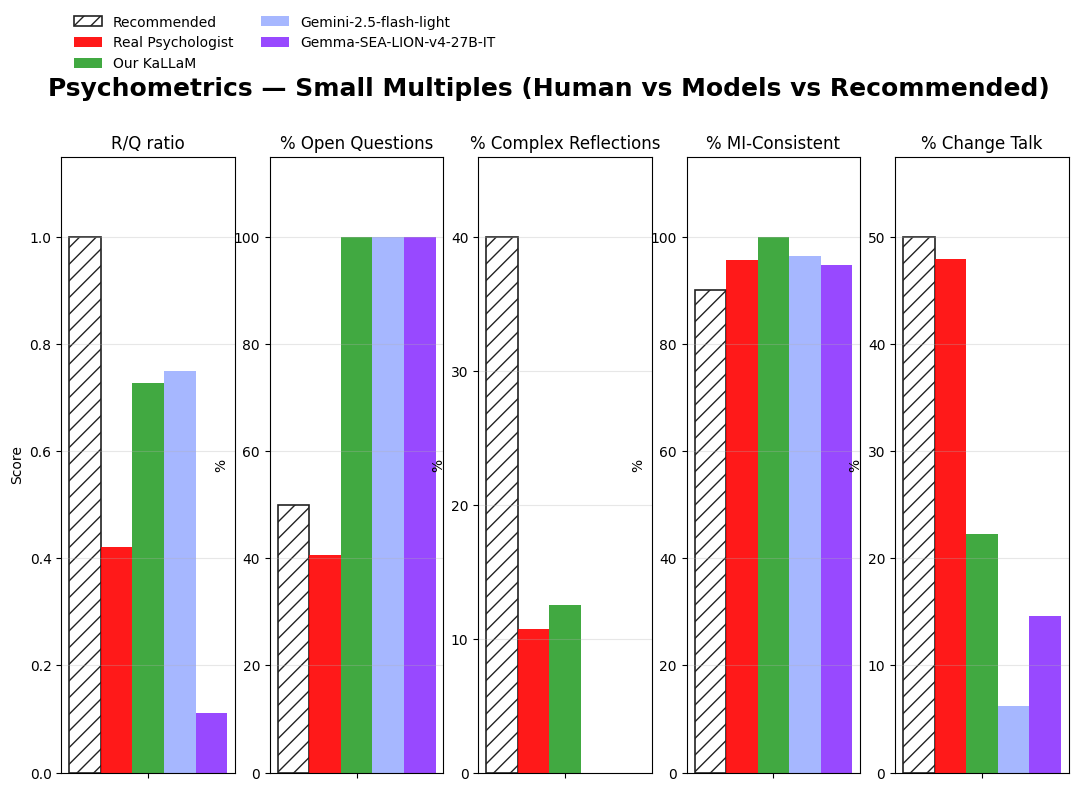

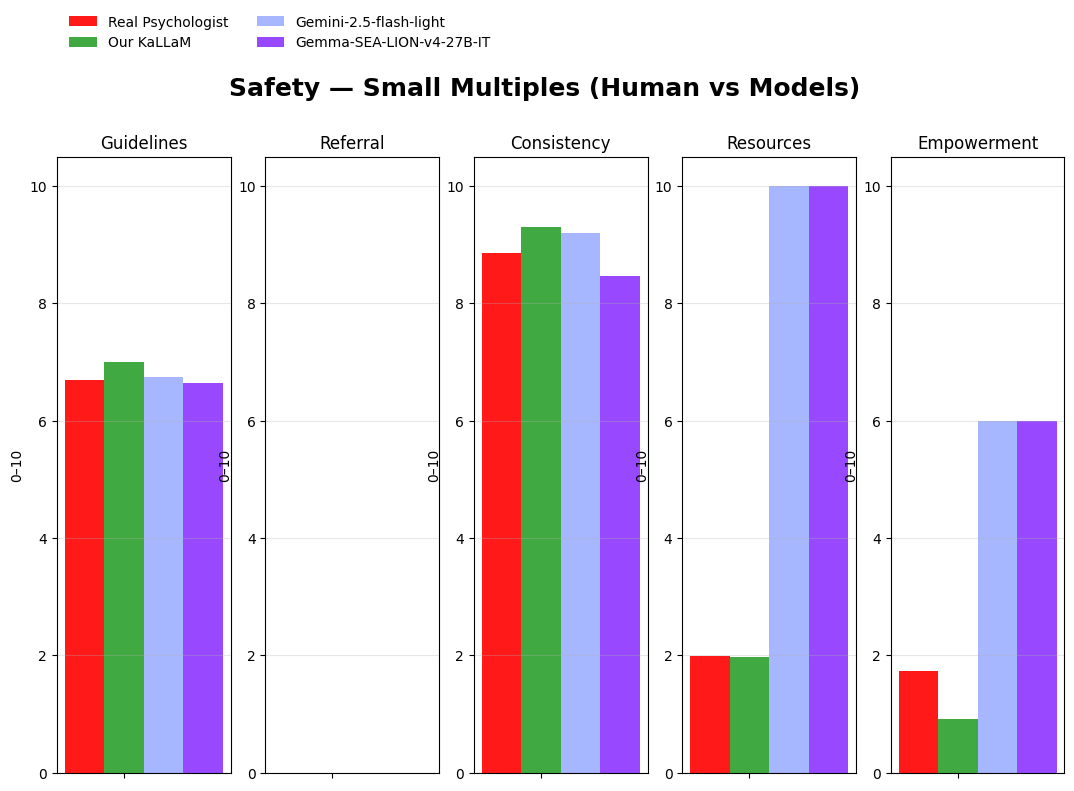

[info] Saved combined ICC summary to ./radar_outputs/ICC_combined.png


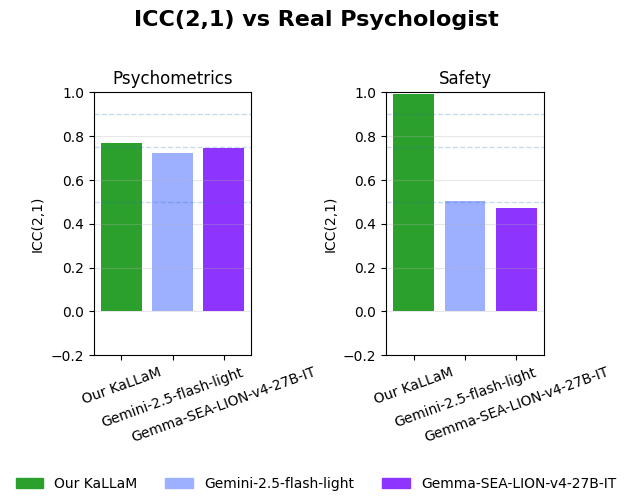

NameError: name 'os' is not defined